<a href="https://colab.research.google.com/github/marcinwolter/Machine-learning-KISD-2022/blob/main/lecture4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>




#**<font color = "red">Introduction to machine learning</font>**

Lecture 4


##**<font color = "green">Cluster analysis</font>**

*16 March 2022*


---

*Marcin Wolter, IFJ PAN*

*e-mail: marcin.wolter@ifj.edu.pl*


---
</center>

#<font color='green'>**Program for today:**


* <span style="color:#00000A">Clustering - find clusters of similar objects</span>


**All slides are here:** 

*https://github.com/marcinwolter/Machine-learning-KISD-2022*




<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/img-2.png'>





# <font color='red'>**Exercise:**

* did you try Boosted Decision Trees for faces classification?
* "Hand made" AdaBoost algorithm.

*Previous lecture with the example "faces" example:*
https://github.com/marcinwolter/Machine-learning-KISD-2022/blob/main/lecture2.ipynb

![](https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture3/MachineLearning2020_41.png)

![](https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture3/MachineLearning2020_42.png)



#**AdaBoost from scratch in python**




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_gaussian_quantiles


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
 
from sklearn import base

from mlxtend.plotting import plot_decision_regions

# **Definition of AdaBoost**

##**Definition 1**

Quite nice and fancy from:
https://github.com/Samarendra109/ML-Models/blob/master/ensemble/AdaBoostClassifier.py

In [ ]:
def indexToVector(y,k,labelDict):
    y_new = []
    for yi in y:
        i = labelDict[yi]
        v = np.ones(k)*(-1/(k-1))
        v[i] = 1
        y_new.append(v)
    return np.array(y_new)

def indexToLabel(i,clf):
    return clf.classes[i]

class MyAdaBoostClassifier:
    
    def __init__(self,base_estimator=None,n_estimators=50):
        self.n_estimators = n_estimators
        self.models = [None]*n_estimators
        if base_estimator == None:
            base_estimator = DecisionTreeClassifier(max_depth=1)
        self.base_estimator = base_estimator
        self.estimator_errors_ = []
        
    def fit(self,X,y):
        
        X = np.float64(X)
        N = len(y)
        w = np.array([1/N for i in range(N)])
        
        self.createLabelDict(np.unique(y))
        k = len(self.classes)
        
        for m in range(self.n_estimators):
            
            Gm = base.clone(self.base_estimator).\
                            fit(X,y,sample_weight=w).predict
            
            incorrect = (Gm(X) != y)
            errM = np.average(incorrect,weights=w,axis=0)
            
            self.estimator_errors_.append(errM)
            
            BetaM = (np.log((1-errM)/errM)+np.log(k-1))
            
            w *= np.exp(BetaM*incorrect*(w > 0))
            
            self.models[m] = (BetaM,Gm)
            
    def createLabelDict(self,classes):
        self.labelDict = {}
        self.classes = classes
        for i,cl in enumerate(classes):
            self.labelDict[cl] = i

    def predict_proba(self,X):
        k = len(self.classes)
        y_pred = sum(Bm*indexToVector(Gm(X),k,self.labelDict) \
                             for Bm,Gm in self.models)
        
        
        return y_pred
    

    def predict(self,X):
        k = len(self.classes)
        y_pred = sum(Bm*indexToVector(Gm(X),k,self.labelDict) \
                             for Bm,Gm in self.models)
        
        iTL = np.vectorize(indexToLabel)
        return iTL(np.argmax(y_pred,axis=1),self)
    


##**Definition 2**

Based on https://geoffruddock.com/adaboost-from-scratch-in-python/

##**Fitting the model**
<p>Recall our algorithm to fit the model:</p>
<ol>
<li>Find weak learner $h_t(x)$ which minimizes $\epsilon_t = \sum_{i=1}^n \mathbf{1}[h_t(x_i) \neq y_i] \, w_i^t$.</li>
<li>We set a weight for our weak learner based on its accuracy: $\alpha_t = \frac{1}{2} \ln \Big( \frac{1-\epsilon_t}{\epsilon_t} \Big)$</li>
<li>Increase weights of misclassified observations: $w_i^{(t+1)} = w_i^{(t)} \cdot e^{-\alpha_t y_i h_t(x_i)}$. Note that $y_i h_t(x_i)$ will evaluate to $+1$ when hypothesis agrees with label, and $-1$ when it does not agree.</li>
<li>Renormalize weights, so that $\sum_{i=1}^n w_i^{(t+1)} =1$.</li>
</ol>
<p>The code below is essentially a 1-to-1 implementation of the above, but there are a few things to note:</p>
<ul>
<li>Since the focus here is understanding the ensemble element of AdaBoost, we&rsquo;ll outsource the logic of picking each $h_t(x)$ to <code>DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)</code>.</li>
<li>We set the initial uniform sample weights outside of the for-loop and set the weights for $t+1$ within each iteration $t$, unless it is the last iteration. </li>
</ul>

In [ ]:
class MyAdaBoost:
    """ AdaBoost enemble classifier from scratch """

    def __init__(self,base_estimator=None,n_estimators=50):
        self.stumps = None
        self.stump_weights = None
        self.errors = None
        self.sample_weights = None
        self.n_estimators = n_estimators
        if base_estimator == None:
            base_estimator = DecisionTreeClassifier(max_depth=1)
        self.base_estimator = base_estimator
        print(base_estimator)

    def _check_X_y(self, X, y):
        """ Validate assumptions about format of input data"""
        # Normalize y to {-1,1}
        ymin = np.min(y)
        ymax = np.max(y)
        y = 2*(y-ymin)/(ymax-ymin)-1
        y = y.astype(int)
        
        assert set(y) == {-1, 1}, 'Response variable must be ±1'
        return X, y

    def fit(self, X: np.ndarray, y: np.ndarray):
        """ Fit the model using training data """
       
        iters = self.n_estimators

        X, y = self._check_X_y(X, y)
        n = X.shape[0]

        # init numpy arrays
        self.sample_weights = np.zeros(shape=(iters, n))
        self.stumps = np.zeros(shape=iters, dtype=object)
        self.stump_weights = np.zeros(shape=iters)
        self.errors = np.zeros(shape=iters)

        # initialize weights uniformly
        self.sample_weights[0] = np.ones(shape=n) / n

        for t in range(iters):
            # fit  weak learner
            curr_sample_weights = self.sample_weights[t]
            # clone the base_estimator to have a fresh estimator ready
            stump = base.clone(self.base_estimator) 
            stump = stump.fit(X, y, sample_weight=curr_sample_weights)

            # calculate error and stump weight from weak learner prediction
            stump_pred = stump.predict(X)
            err = curr_sample_weights[(stump_pred != y)].sum()# / n
            stump_weight = np.log((1 - err) / err) / 2

            # update sample weights
            new_sample_weights = (
                curr_sample_weights * np.exp(-stump_weight * y * stump_pred)
            )
            
            new_sample_weights /= new_sample_weights.sum()

            # If not final iteration, update sample weights for t+1
            if t+1 < iters:
                self.sample_weights[t+1] = new_sample_weights

            # save results of iteration
            self.stumps[t] = stump
            self.stump_weights[t] = stump_weight
            self.errors[t] = err

        return self

    def predict(self, X):
        """ Make predictions using already fitted model """
        stump_preds = np.array([stump.predict(X) for stump in self.stumps])
        preds = np.sign(np.dot(self.stump_weights, stump_preds))
        preds = (preds+1)/2
        return preds.astype(int)

    def predict_proba(self, X):
        """ Make predictions using already fitted model """
        stump_preds = np.array([stump.predict(X) for stump in self.stumps])
        preds = np.dot(self.stump_weights, stump_preds)
        preds = (preds+1.)/2.
        return np.stack((1-preds, preds), axis = 1)             

In [ ]:

# Construct dataset
X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=80, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=120, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))



# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, shuffle=True)




In [ ]:

# Create and fit a classifier
clf = MyAdaBoost(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=20)
#clf = MyAdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),n_estimators=20)
#clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),n_estimators=20)

#clf = GaussianNB()
#clf = MyAdaBoost(base_estimator=GaussianNB(),n_estimators=10)
#clf = MyAdaBoostClassifier(base_estimator=GaussianNB(),n_estimators=10) 
#clf = MyAdaBoostClassifier(base_estimator=GaussianNB(),n_estimators=0) 



clf.fit(X_train, y_train)

print("Predicted class:")
clf.predict(X_train)

DecisionTreeClassifier(max_depth=1)
Predicted class:


array([0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0])

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


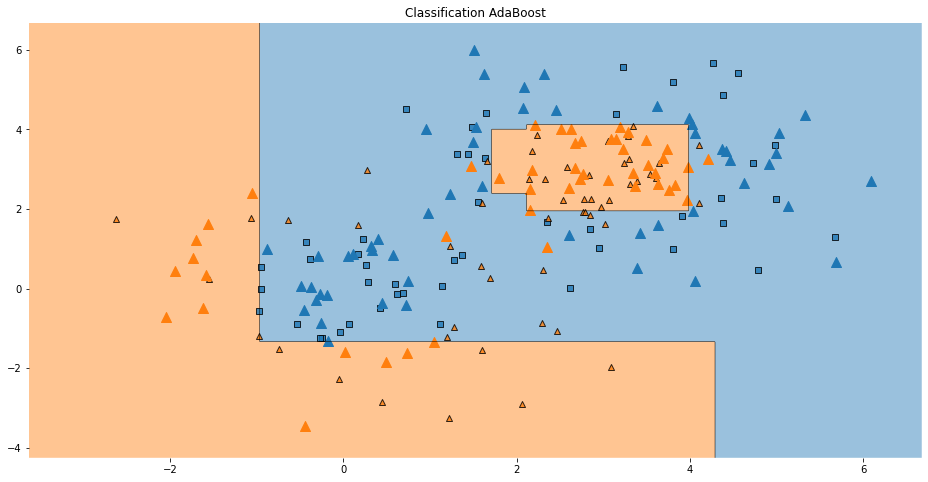

In [ ]:



plt.figure(figsize=(16, 8))
plot_decision_regions(X_test, y_test.astype(int), clf=clf, legend=0, colors='#1f77b4,#ff7f0e,#ffec6e')   

# Plot also the training points
for i in range(2):
    plt.scatter(X_train[np.where(y_train==i), 0], X_train[np.where(y_train==i), 1],s=100, marker='^')    

plt.title("Classification AdaBoost")


plt.show()

Text(0.7, 0.5, 'AUC = 0.89')

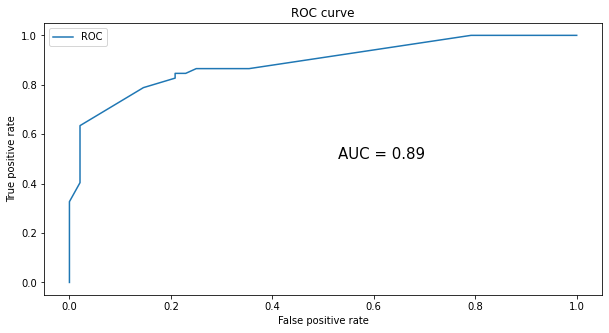

In [ ]:
        # plot the roc curve
        figure = plt.figure(figsize=(10, 5))
        ZZ = clf.predict_proba(X_test)[:, 1]
        
        fpr, tpr, _ = roc_curve(y_test, ZZ)
        plt.plot(fpr, tpr, label="ROC")
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        auc = roc_auc_score(y_test, ZZ)
        plt.text(0.7, 0.5, ('AUC = %.2f' % auc),
                size=15, horizontalalignment='right')

#<font color='green'> **What is clustering?**

A grouping of data objects such that the **objects within a group are similar** (or related) to one another and **diﬀerent from** (or unrelated to) **the objects in other groups**.

Distances between clusters are maximized and intra-cluster distances are minimized.

<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/Screenshot from 2022-03-12 16-48-22.png' width=450px>

Outliers are objects that do not belong to any cluster or form clusters of very small cardinality (number of cluster members).
In some applications we are interested in discovering outliers, not
clusters (outlier analysis).

<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/Screenshot from 2022-03-12 18-04-30.png' width=450px>

#<font color='green'> **Kraków 1804**


<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/Screenshot from 2022-03-12 18-13-26.png' width=650px>


<span style="color:#C9211E"> __The__ </span>      <span style="color:#C9211E"> __clustering__ </span>      <span style="color:#C9211E"> __task__ </span>

<span style="color:#000000">•</span>  <span style="color:#000000"> </span>  <span style="color:#000000">Assign</span>  <span style="color:#000000"> </span>  <span style="color:#000000">observations</span>  <span style="color:#000000"> </span>  <span style="color:#000000">into</span>  <span style="color:#000000"> </span>  <span style="color:#000000">groups</span>  <span style="color:#000000"> </span>  <span style="color:#000000">so</span>  <span style="color:#000000"> </span>  <span style="color:#000000">that</span>  <span style="color:#000000"> </span>  <span style="color:#000000">the</span>  <span style="color:#000000"> </span>  <span style="color:#000000">observations</span>  <span style="color:#000000"> </span>  <span style="color:#000000">belonging</span>  <span style="color:#000000"> </span>  <span style="color:#000000">in</span>  <span style="color:#000000"> </span>  <span style="color:#000000">the</span>
<span style="color:#000000">same</span>  <span style="color:#000000"> </span>  <span style="color:#000000">group</span>  <span style="color:#000000"> </span>  <span style="color:#000000">are</span>  <span style="color:#000000"> </span>  <span style="color:#000000">similar\,</span>  <span style="color:#000000"> </span>  <span style="color:#000000">whereas</span>  <span style="color:#000000"> </span>  <span style="color:#000000">observations</span>  <span style="color:#000000"> </span>  <span style="color:#000000">in</span>  <span style="color:#000000"> </span>  <span style="color:#000000">different</span>  <span style="color:#000000"> </span>  <span style="color:#000000">groups</span>  <span style="color:#000000"> </span>  <span style="color:#000000">are</span>
<span style="color:#000000">different</span>  <span style="color:#000000"> </span>  <span style="color:#000000">=></span>

<span style="color:#000000">•</span>  <span style="color:#000000"> </span>  <span style="color:#000000"> __We__ </span>     <span style="color:#000000"> __need__ </span>     <span style="color:#000000"> __a__ </span>     <span style="color:#000000"> __distance__ </span>     <span style="color:#000000"> __between__ </span>     <span style="color:#000000"> __points:__ </span>

<span style="color:#000000">The</span>  <span style="color:#000000"> </span>  <span style="color:#000000">distance</span>  <span style="color:#000000"> </span>  <span style="color:#4F81BD"> __d\(x\,__ </span>      <span style="color:#4F81BD"> __y\)__ </span>      <span style="color:#000000">between</span>  <span style="color:#000000"> </span>  <span style="color:#000000">two</span>  <span style="color:#000000"> </span>  <span style="color:#000000">objects</span>  <span style="color:#000000"> </span>  <span style="color:#4F81BD"> __x__ </span>      <span style="color:#000000">and</span>  <span style="color:#000000"> </span>  <span style="color:#4F81BD"> __y__ </span>      <span style="color:#000000">is</span>  <span style="color:#000000"> </span>  <span style="color:#000000">a</span>  <span style="color:#000000"> </span>  <span style="color:#FF0000">metric</span>  <span style="color:#FF0000"> </span>  <span style="color:#000000">if:</span>

* <span style="color:#4F81BD"> __d\(i\,__ </span>      <span style="color:#4F81BD"> __j\)__ </span>  $\ge$  <span style="color:#4F81BD"> __0__ </span>      <span style="color:#000000">\(</span>  <span style="color:#FF0000">non\-negativity</span>  <span style="color:#000000">\)</span>

* <span style="color:#4F81BD"> __d\(i\,__ </span>      <span style="color:#4F81BD"> __i\)=0__ </span>      <span style="color:#000000">\(</span>  <span style="color:#FF0000">isolation</span>  <span style="color:#000000">\)</span>

* <span style="color:#4F81BD"> __d\(i\,__ </span>      <span style="color:#4F81BD"> __j\)=__ </span>      <span style="color:#4F81BD"> __d\(j\,__ </span>      <span style="color:#4F81BD"> __i\)__ </span>      <span style="color:#000000">\(</span>  <span style="color:#FF0000">symmetry</span>  <span style="color:#000000">\)</span>

* <span style="color:#4F81BD"> __d\(i\,__ </span>      <span style="color:#4F81BD"> __j\)__ </span>      <span style="color:#4F81BD"> __≤__ </span>      <span style="color:#4F81BD"> __d\(i\,__ </span>      <span style="color:#4F81BD"> __h\)\+d\(h\,__ </span>      <span style="color:#4F81BD"> __j\)__ </span>      <span style="color:#000000">\(</span>  <span style="color:#FF0000">triangular</span>  <span style="color:#FF0000"> </span>  <span style="color:#FF0000">inequality</span>  <span style="color:#000000">\)</span>


#<font color='green'> **Distance**



<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/img-7.png' width=450px>
<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/img-8.png' width=450px>
<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/img-9.png' width=450px>

...and many others.

#<font color='green'> **Data structures**



<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/Screenshot from 2022-03-12 18-20-02.png' width=650px>

# <font color='green'> **Non-hierarchical methods**

##**k-means algorithm**

• Given a set $X$ of $n$ points in a d-dimensional space and an integer $k$

• **Task:** choose a set of $k$ points (cluster centers) $\{c_1, c_2,...,c_k\}$ in the $d$-dimensional space to form clusters $\{C_1, C_2,...,C_k\}$, such that the cost:

$$ Cost(C) = \sum_{i=1}^k \sum_{x \in C_i} d(x,c_i)^2$$

is minimized and $d(x,c_i)$ denotes a distance between $x$ and $c_i$.

• **Some special cases:** $k = 1$ (one cluster), $k = n$ (each element is its own cluster).

• **Important:** the number of clusters $k$ must be chosen in advance.


# **The k-means algorithm in detail**
* Randomly pick $k$ cluster centers $\{c_1,...,c_k\}$
* For each $i$, set the cluster $C_i$ to be the set of points in $X$ that are
closer to the center $c_i$ than they are to $c_j$ for all $i\ne j$
* For each $i$ let $c_i$ be the center of cluster $C_i$ (mean of the vectors of all points in $C_i$)
* Repeat until convergence

<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/img-13.png' width=650px>

#**Properties of the k-means algorithm**
* Finds a local optimum
* Converges often quickly (but not always)
* The choice of initial points can have large influence on the result.

##**Two different outcomes of k-mean clustering**


<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/Screenshot from 2022-03-12 21-44-34.png' width=650px>

##**Some alternatives to random initialization of the central points**
* Multiple runs
 * Helps, but probability is not on your side
* Select original set of points by methods other than random,
e.g. pick the most distant (from each other) points as cluster
centers (*kmeans++* algorithm in Scikit Learn)

<font color='blue'> **The *k-means* algorithm clusters data by trying to separate
samples in n groups of equal variance, minimizing a criterion
known as the inertia or within-cluster sum-of-squares. This algorithm requires the number of clusters to be
specified. It scales well to large number of samples and has
been used across a large range of application areas in many
different fields.**

In [ ]:
%matplotlib inline


# Demonstration of k-means assumptions


This example is meant to illustrate situations where k-means will produce
unintuitive and possibly unexpected clusters. In the first three plots, the
input data does not conform to some implicit assumption that k-means makes and
undesirable clusters are produced as a result. In the last plot, k-means
returns intuitive clusters despite unevenly sized blobs.


Automatically created module for IPython interactive environment


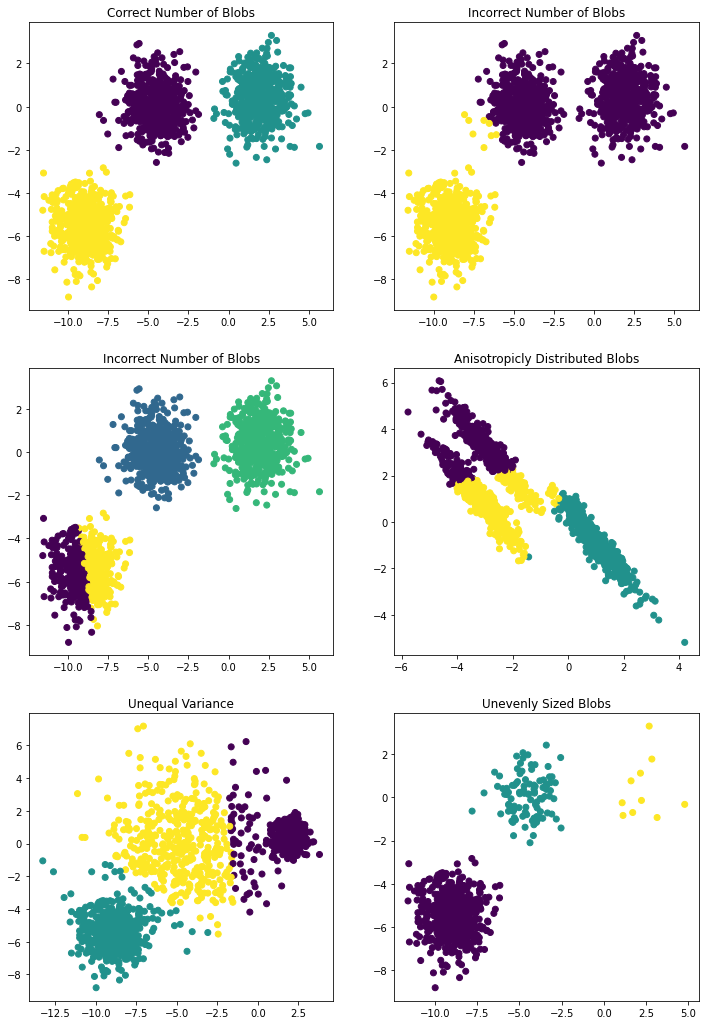

In [ ]:
print(__doc__)

# Author: Phil Roth <mr.phil.roth@gmail.com>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.figure(figsize=(12, 18))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Correct number of clusters
y_pred = KMeans(n_clusters=3, init='random', random_state=random_state).fit_predict(X) #init=k-means++

plt.subplot(321)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Correct Number of Blobs")


# Incorrect number of clusters
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.subplot(322)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")


# Incorrect number of clusters
y_pred = KMeans(n_clusters=4, random_state=random_state).fit_predict(X)

plt.subplot(323)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")

# Anisotropicly distributed data
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)

plt.subplot(324)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Anisotropicly Distributed Blobs")

# Different variance
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.subplot(325)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("Unequal Variance")

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = KMeans(n_clusters=3,
                random_state=random_state).fit_predict(X_filtered)

plt.subplot(326)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Unevenly Sized Blobs")

plt.show()

#<font color='green'>**Hierarchical Clustering**
* Produces a set of nested clusters organized as a hierarchical tree.
* Can be visualized as a dendrogram - a tree-like diagram that records the sequences of merges or splits.

<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/Screenshot from 2022-03-12 22-20-57.png' width=650px>

##**Strengths of Hierarchical Clustering**
* No assumptions on the number of clusters
 * Any desired number of clusters can be obtained by ‘cutting’ the
dendrogram at the proper level
* Hierarchical clustering may correspond to some meaningful features

#**Two main types of hierarchical clustering:**
* **Agglomerative:**
 * Start with the points as individual clusters
 * At each step, merge the closest pair of clusters until only one
cluster (or k clusters) left
*  **Divisive:**
 * Start with one, all-inclusive cluster
 * At each step, split a cluster until each cluster contains a point
(or the number of clusters reaches the limit)

#**Complexity of hierarchical clustering**
* Distance matrix is used for deciding which clusters to merge/split
* CPU - at least quadratic in the number of data points
* Not usable for large datasets

#<font color='green'>**Agglomerative clustering algorithm**
* Most popular hierarchical clustering technique
* Basic algorithm
 <font color='blue'>

 1. Compute the distance matrix between the input data points
 2. Let each data point be a cluster
 3. **Repeat**
   4. Merge the two closest clusters
   5. Update the distance matrix
 6. **Until** only a single cluster remains

 </font>
* Key operation is the computation of the distance between two
clusters
 * Different definitions of the distance between clusters lead to
different algorithms

##**Input / Initial setting**
* Start with clusters of individual points and a distance/proximity matrix


<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/Screenshot from 2022-03-12 22-55-28.png' width=450px>

* After some merging steps, we have some clusters

<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/Screenshot from 2022-03-12 22-55-56.png' width=450px>

* Merge the two closest clusters (C2 and C5) and update the distance
matrix.

<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/Screenshot from 2022-03-12 22-56-31.png' width=450px>

* **After Merging:**  “How do we update the distance matrix?”


<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/Screenshot from 2022-03-12 22-57-43.png' width=450px>



#**Distance between two clusters**
* Each cluster is a set of points
* How do we define distance between two sets of points?
 * Lots of alternatives
 * Not an easy task

#**Distance between two clusters - single-link distance**
* **Single-link distance** between clusters $C_i$ and $C_j$ is the minimum distance
between any object in $C_i$ and any object in $C_j$
* The distance is defined by the two most similar objects:

$$ D_{sl}(C_i, C_j) = \min \left| d(x,y) \right| \ x\in C_i, y\in C_j$$

<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/img-16.png' width=250px>

#**Strengths of single-link clustering**

Can handle non-elliptical shapes


<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/img-19.png' width=350px>

Original points

<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/img-18.jpg' width=350px>

Two clusters


#**Limitations of single-link clustering**

<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/img-20.png' width=350px>

Original points

<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/img-21.png' width=350px>

Two clusters


* Sensitive to noise and outliers
* Produces long, elongated clusters


#**Distance between two clusters - complete-link distance**
* Complete-link distance between clusters $C_i$ and $C_j$ is the maximum
distance between any object in $C_i$ and any object in $C_j$
* The distance is defined by the two most dissimilar objects:

$$ D_{cl}(C_i, C_j) = \max \left| d(x,y) \right| \ x\in C_i, y\in C_j$$


<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/img-22.png' width=250px>

#**Strengths of complete-link clustering**

* More balanced clusters (with equal diameter)
* Less susceptible to noise


<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/img-23.png' width=350px>

Original points

<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/img-24.png' width=350px>

Two clusters


#**Limitations of complete-link clustering**


* Tends to break large clusters
* All clusters tend to have the same diameter – small
clusters are merged with larger ones



<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/img-25.png' width=350px>

Original points

<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/img-26.png' width=350px>

Two clusters


#**Distance between two clusters - group average distance**

* Group average distance between clusters $C_i$ and $C_j$ is the average
distance between any object in $C_i$ and any object in $C_j$


$$ D_{avg}(C_i, C_j) = \frac{ \sum_{x\in C_i, y\in C_j } \left| d(x,y) \right| } {N_i \cdot N_j }$$

where $N_i$ and $N_j$ are the numbers of elements in $C_i$ and $C_j$.


<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/img-27.png' width=250px>

#**Distance between two clusters - Ward's distance**
* **Ward’s distance** between clusters $C_i$ and $C_j$ is the difference
between the total within cluster sum of squares for the two
clusters separately, and the within cluster sum of squares
resulting from merging the two clusters in cluster $C_{ij}$.


$$ D_{Ward}(C_i, C_j) = \sum_{x\in C_i } (x - r_i)^2 + \sum_{x\in C_j } (x - r_j)^2  -  \sum_{x\in C_{ij} } (x - r_{ij})^2 
 $$

where:
* $r_i$: centroid of $C_i$
* $r_j$: centroid of $C_j$
* $r_{ij}$: centroid of $C_{ij}$




<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture4/img-29.png' width=450px>


#**Ward’s distance for clusters**
* Similar to group average and centroid distance
* Less susceptible to noise and outliers
* Hierarchical analogue of k-means algorithm
 * can be used to initialize k-means


In [ ]:
%matplotlib inline


# Comparing different hierarchical linkage methods on toy datasets


This example shows characteristics of different linkage
methods for hierarchical clustering on datasets that are
"interesting" but still in 2D.

The main observations to make are:

- single linkage is fast, and can perform well on
  non-globular data, but it performs poorly in the
  presence of noise.
- average and complete linkage perform well on
  cleanly separated globular clusters, but have mixed
  results otherwise.
- Ward is the most effective method for noisy data.

While these examples give some intuition about the
algorithms, this intuition might not apply to very high
dimensional data.


In [ ]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

from scipy.cluster.hierarchy import dendrogram

np.random.seed(0)

Automatically created module for IPython interactive environment


In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


Generate datasets. We choose the size big enough to see the scalability
of the algorithms, but not too big to avoid too long running times



In [ ]:
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

Run the clustering and plot



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

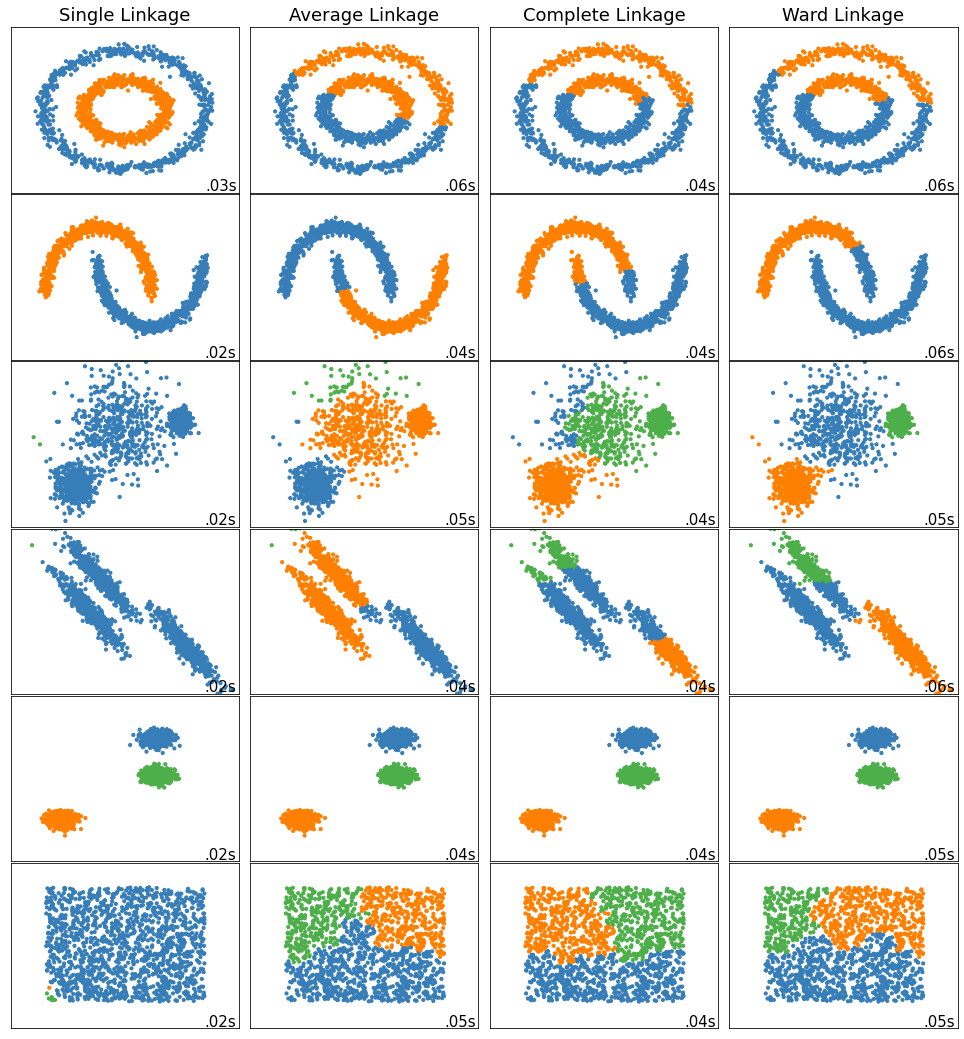

In [ ]:
# Set up cluster parameters
plt.figure(figsize=(9 * 1.3 + 2, 14.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2}),
    (varied, {'n_neighbors': 2}),
    (aniso, {'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward')
    complete = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='complete')
    average = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='average')
    single = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='single')

    clustering_algorithms = (
        ('Single Linkage', single),
        ('Average Linkage', average),
        ('Complete Linkage', complete),
        ('Ward Linkage', ward),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            algorithm=algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        


        plot_num += 1
 

plt.show()


Plot dendrograms for Blobs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

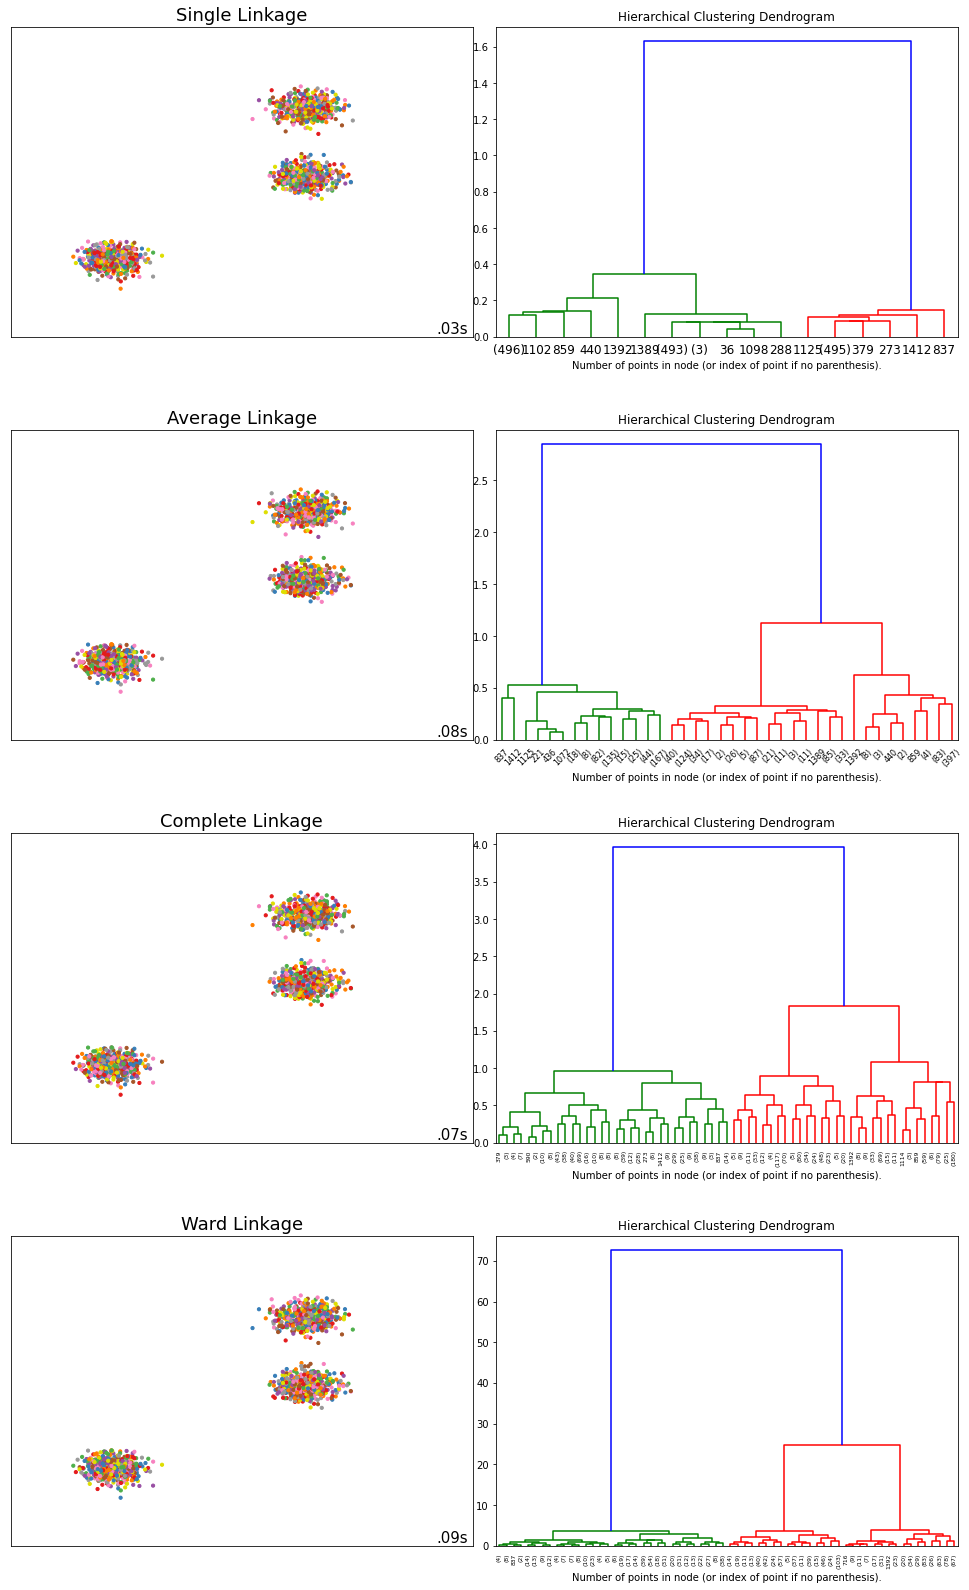

In [ ]:
    # Set up cluster parameters
    plt.figure(figsize=(9 * 1.3 + 2, 22))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=0.3)

    i_dataset = 0
    plot_num = 1

    X, y = blobs


    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============
    ward = cluster.AgglomerativeClustering(
        distance_threshold=0, n_clusters=None, linkage='ward')
    complete = cluster.AgglomerativeClustering(
        distance_threshold=0, n_clusters=None, linkage='complete')
    average = cluster.AgglomerativeClustering(
        distance_threshold=0, n_clusters=None, linkage='average')
    single = cluster.AgglomerativeClustering(
        distance_threshold=0, n_clusters=None, linkage='single')

    clustering_algorithms = (
        ('Single Linkage', single),
        ('Average Linkage', average),
        ('Complete Linkage', complete),
        ('Ward Linkage', ward),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()
        
        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            algorithm=algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(clustering_algorithms), 2, plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10,  color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        
        plt.subplot(len(clustering_algorithms), 2, plot_num + 1)
        plt.title('Hierarchical Clustering Dendrogram')
        # plot the top four levels of the dendrogram
        plot_dendrogram(algorithm, truncate_mode='level', p=5)
        plt.xlabel("Number of points in node (or index of point if no parenthesis).")

        plot_num += 2
 

plt.show()




#<font color='green'> **Summary**
* Clustering analysis is broadly used in many applications
such as market research, pattern recognition, data
analysis, and image processing.
* As a data mining function, cluster analysis serves as a tool
to gain insight into the distribution of data to observe
characteristics of each cluster.
